In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import os
import json
from pandas.io.json import json_normalize
import pmdarima
from sklearn.model_selection import train_test_split
from pmdarima.arima import ADFTest
from sklearn.metrics import r2_score
import tsfresh
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from  tsfresh.feature_extraction  import  extract_features 

In [ ]:
#5 минут - 288 измерений
#15 минут - 96 измерений
#30 минут - 48 измерений
#60 минут - 24 измерения
#120 минут - 12 измерений

In [4]:
data_folder = 'C:/Users/Svetlana/Documents/flink_metric_data_new/'
folder = []
for i in os.walk('C:/Users/Svetlana/Documents/flink_metric_data_new'):
    folder.append(i)
    

In [5]:
data_folder = 'C:/Users/Svetlana/Documents/flink_metric_data_new/'
with open(f"{data_folder}10h4id8fd1ii4477diifdd5d3iig9596_15360_129942_read_records_per_second.json") as f:
    data = json.load(f)
    df = pd.DataFrame(data['datapoints'])
    df.drop('unit',axis=1,inplace=True)

<h1>Подготовка данных</h1>
Удаляем данные длина которых меньше 2017(57), так как это слишком маленький объем для обучения и данные которые на всем промежутке содержать только одно уникальное значение(~326), в большинстве своем это нулевые ряды, так же есть константые, но они не несут существенной информации о колебании нагрузки.

В датафрейме "common_df2.csv" содержатся оставшиеся "хорошие" данные.

In [6]:
common_df=pd.read_csv(r"C:\Users\Svetlana\Documents\common_df2.csv")

In [5]:
common_df.head()

,Unnamed: 0,name,max,min,range,coef_var,len,uniq
0,0,10h4id8fd1ii4477diifdd5d3iig9596_15360_129942_...,54629.51,4288.55,50340.96,0.380349,2017,1954
1,1,10h4id8fd1ii4477diifdd5d3iig9596_15360_129942_...,54655.37,4290.59,50364.78,0.380330,2017,1969
2,2,10h4id8fd1ii4477diifdd5d3iig9596_15360_130545_...,24342.99,3429.66,20913.33,0.066767,2017,1926
3,3,10h4id8fd1ii4477diifdd5d3iig9596_15360_130545_...,24341.42,3429.52,20911.90,0.066759,2017,1935
4,4,10h4id8fd1ii4477diifdd5d3iig9596_15360_149764_...,806.71,127.28,679.43,0.182366,2017,725


In [ ]:
#кусочек кода для работы с конкретным рядом

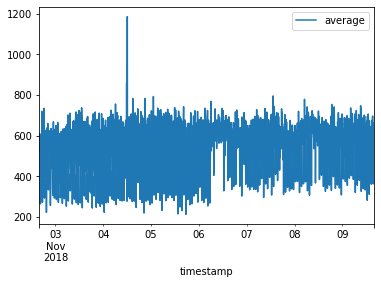

In [99]:
s=common_df.at[13, 'name']
with open(f"{data_folder}"+'/'+s) as f:
    data = json.load(f)
    df = pd.DataFrame(data['datapoints'])
    df.drop('unit',axis=1,inplace=True)
    df = df.set_index(['timestamp'])
    df.index = pd.to_datetime(df.index, unit='ms')
df.plot()

<h3>Простое экспоненциальное сглаживание <h3>

In [20]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

проверим как ресемплинг влияет на точность предсказаний

для начала исходная джоба с шагом 5 минут и простое экспоненциальное сглаживание, предсказываем на день

<h2>Интервалы по 5 минут</h2>

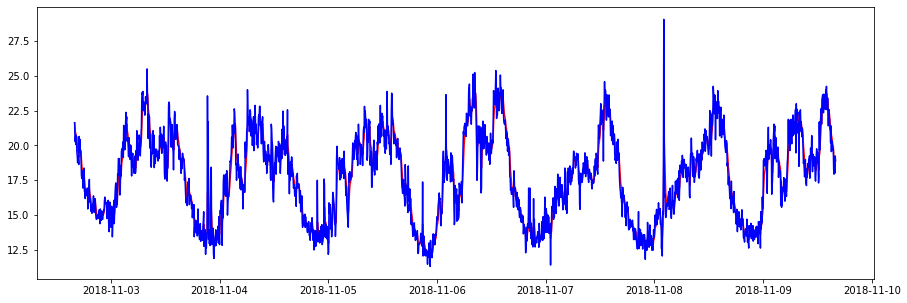

In [107]:
ex_sm=exponential_smoothing(df.average, 0.3)
ex=pd.DataFrame({'average': ex_sm}, index=df.index)
plt.figure(figsize=(15,5))
plt.plot(ex, color='red')
plt.plot(df.average[:], color='blue')


In [67]:
from sklearn.metrics import mean_squared_error

In [108]:
mean_squared_error(df.average, ex_sm)

0.6196012016193219

<h2>Интервал 15 минут</h2>

In [109]:
df_resample_15T = pd.DataFrame()
df_resample_15T['average'] = df.average.resample('15T').sum()

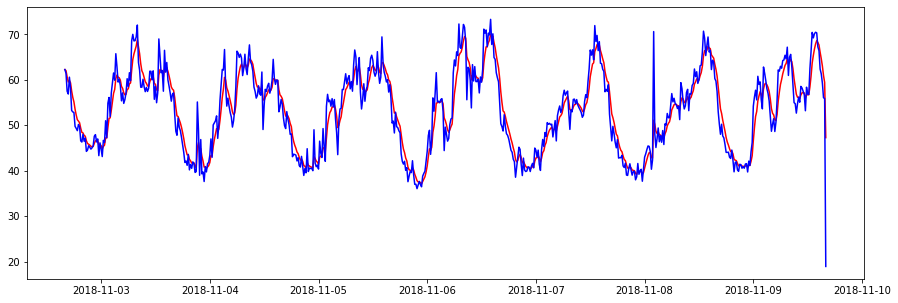

In [110]:
ex_sm1=exponential_smoothing(df_resample_15T.average, 0.3)
ex1=pd.DataFrame({'average': ex_sm1}, index=df_resample_15T.index)
plt.figure(figsize=(15,5))
plt.plot(ex1, color='red')
plt.plot(df_resample_15T.average[:], color='blue')

In [111]:
mean_squared_error(df_resample_15T.average, ex_sm1)

9.223539267489029

<h2>Интервал 30 минут</h2>

In [112]:
df_resample_30T = pd.DataFrame()
df_resample_30T['average'] = df.average.resample('30T').sum()

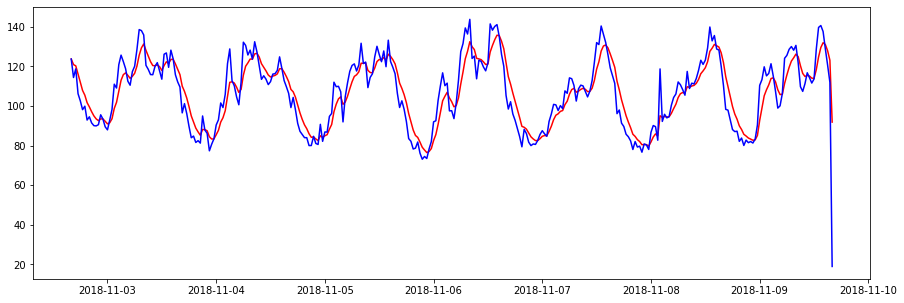

In [113]:
ex_sm2=exponential_smoothing(df_resample_30T.average, 0.3)
ex2=pd.DataFrame({'average': ex_sm2}, index=df_resample_30T.index)
plt.figure(figsize=(15,5))
plt.plot(ex2, color='red')
plt.plot(df_resample_30T.average[:], color='blue')

In [114]:
mean_squared_error(ex_sm2, df_resample_30T.average)

66.8006654649789

<h1>Интервал 60 минут</h1>

In [100]:
df_resample_60T = pd.DataFrame()
df_resample_60T['average'] = df.average.resample('60T').sum()

In [21]:
ex_sm3=exponential_smoothing(df_resample_60T.average, 0.3)

In [22]:
ex3=pd.DataFrame({'average': ex_sm3}, index=df_resample_60T.index)

In [32]:
plt.figure(figsize=(15,5))
plt.plot(ex3, color='red')
plt.plot(df_resample_60T.average[:], color='blue')

NameError: name 'ex3' is not defined

<Figure size 1080x360 with 0 Axes>

In [119]:
mean_squared_error(ex_sm3,df_resample_60T)

507.94385359526746

<h2>1.5 часа</h2>

In [120]:
df_resample_90T = pd.DataFrame()
df_resample_90T['average'] = df.average.resample('90T').sum()

In [121]:
ex_sm4=exponential_smoothing(df_resample_90T.average, 0.3)

In [122]:
ex4=pd.DataFrame({'average': ex_sm4}, index=df_resample_90T.index)

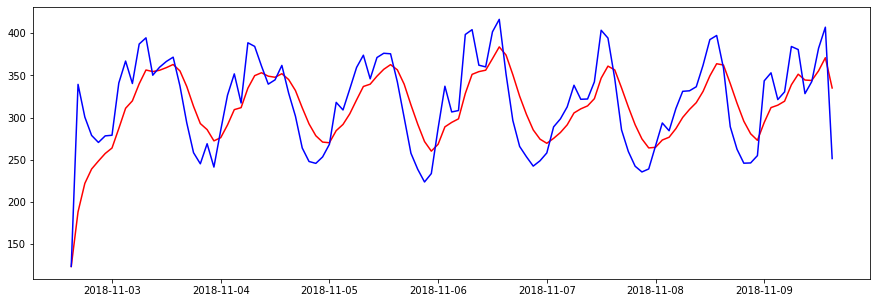

In [123]:
plt.figure(figsize=(15,5))
plt.plot(ex4, color='red')
plt.plot(df_resample_90T.average, color='blue')


In [124]:
mean_squared_error(df_resample_90T, ex_sm4)

1385.4005438606737

<h2>2 часа</h2>

In [125]:
df_resample_120T = pd.DataFrame()
df_resample_120T['average'] = df.average.resample('120T').sum()

In [126]:
ex_sm5=exponential_smoothing(df_resample_120T.average, 0.3)

In [127]:
ex5=pd.DataFrame({'average': ex_sm5}, index=df_resample_120T.index)

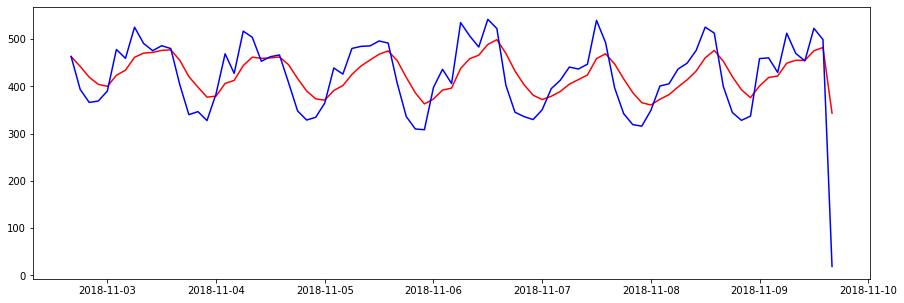

In [128]:
plt.figure(figsize=(15,5))
plt.plot(ex5, color='red')
plt.plot(df_resample_120T.average[:], color='blue')

In [129]:
mean_squared_error(df_resample_120T, ex_sm5)

3359.4095728205934

MSE с каждым ресемплингом увеличивается, самый лучший результат без ресемплинга

проверим ряд на стационарность

In [52]:
from statsmodels.tsa.stattools import adfuller
#adf_test=ADFTest(alpha=0.05)
#adf_test.should_diff(df_resample_60T)

In [53]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(series):
    result=adfuller(series)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [101]:
adfuller_test(df_resample_60T.average)

ADF Test Statistic : -2.0891392140056326
p-value : 0.24890414455796483
#Lags Used : 1
Number of Observations Used : 167
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


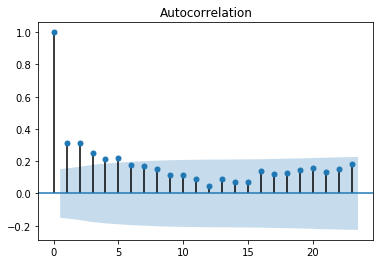

In [102]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_resample_60T.average)
plt.show()

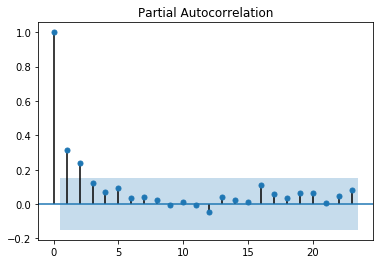

In [103]:
from statsmodels.graphics.tsaplots import plot_pacf
series = df_resample_60T.average
plot_pacf(series)#lags=50
plt.show()

Тест Дики Фуллера говорит, что ряд стационарный, но автокорелляционный график показывает обратное.

Для избавления от нестационарности используется численное  дифференцирование со сдвигом равным сезону.

In [57]:
df_resample_60T['first_diff']=df_resample_60T['average']-df_resample_60T['average'].shift(24)

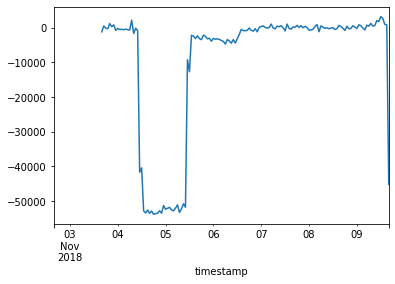

In [58]:
df_resample_60T.first_diff.plot()

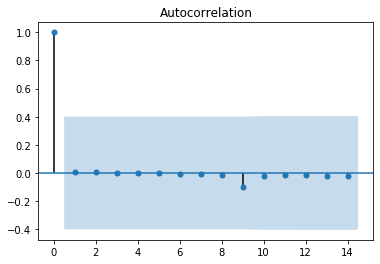

In [40]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_resample_60T.first_diff[-24:])
plt.show()

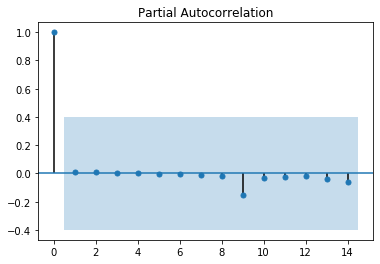

In [41]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_resample_60T.first_diff[-24:])
plt.show()

<b>Вывод: нужно проверить скопипащенный тест Фюллера и почитать про автокорреляцию чтобы понять где конкретно ошибка.</b>

<h2>SARIMA</h2>

Эта модель учитывает сезонную компоненту, поэтому можно не волноваться о нестационарности ряда. Подберем автоматически с помощью auto_arima наилучшие параметры p,d,q

In [104]:
train,test=train_test_split(df_resample_60T.average, shuffle=False)

In [105]:
from pmdarima.arima import auto_arima
arima_model=auto_arima(train,seasonal=True,
                       start_p=0, start_q=0, max_p=5, max_q=5,
                  trace=True, random_state=20, suppress_warnings=True, error_action='ignore',stepwice=True) #seasonal=True
arima_model

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1776.500, BIC=1782.157, Time=0.018 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1751.910, BIC=1760.395, Time=0.091 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1750.983, BIC=1759.468, Time=0.080 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=1774.620, BIC=1777.448, Time=0.012 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1751.973, BIC=1763.286, Time=0.062 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=1752.078, BIC=1763.391, Time=0.150 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=1753.963, BIC=1768.105, Time=0.173 seconds
Total fit time: 0.596 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [106]:
model = sm.tsa.ARIMA(train, (0,1,1)).fit()

In [107]:
pred = model.predict(start=test.index[0], end=test.index[-1])

In [35]:
import statsmodels.api as sm

In [49]:
model = sm.tsa.ARMA(train, (2,2)).fit()

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [45]:
pred = model.predict(start=test.index[0], end=test.index[-1])

In [61]:
print(pred)

2018-11-07 22:00:00   -0.000215
2018-11-07 23:00:00   -0.000274
2018-11-08 00:00:00    0.002079
2018-11-08 01:00:00    0.000524
2018-11-08 02:00:00    0.002356
2018-11-08 03:00:00    0.000620
2018-11-08 04:00:00    0.002389
2018-11-08 05:00:00    0.000632
2018-11-08 06:00:00    0.002393
2018-11-08 07:00:00    0.000634
2018-11-08 08:00:00    0.002393
2018-11-08 09:00:00    0.000634
2018-11-08 10:00:00    0.002393
2018-11-08 11:00:00    0.000634
2018-11-08 12:00:00    0.002392
2018-11-08 13:00:00    0.000635
2018-11-08 14:00:00    0.002392
2018-11-08 15:00:00    0.000635
2018-11-08 16:00:00    0.002392
2018-11-08 17:00:00    0.000635
2018-11-08 18:00:00    0.002391
2018-11-08 19:00:00    0.000636
2018-11-08 20:00:00    0.002391
2018-11-08 21:00:00    0.000636
2018-11-08 22:00:00    0.002391
2018-11-08 23:00:00    0.000636
2018-11-09 00:00:00    0.002391
2018-11-09 01:00:00    0.000637
2018-11-09 02:00:00    0.002390
2018-11-09 03:00:00    0.000637
2018-11-09 04:00:00    0.002390
2018-11-

In [109]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(0, 1, 1)).fit()
pred = mod.predict(start=test.index[0], end=test.index[-1])

In [78]:
#mod.plot_diagnostics(figsize=(15,12))
#plt.show()

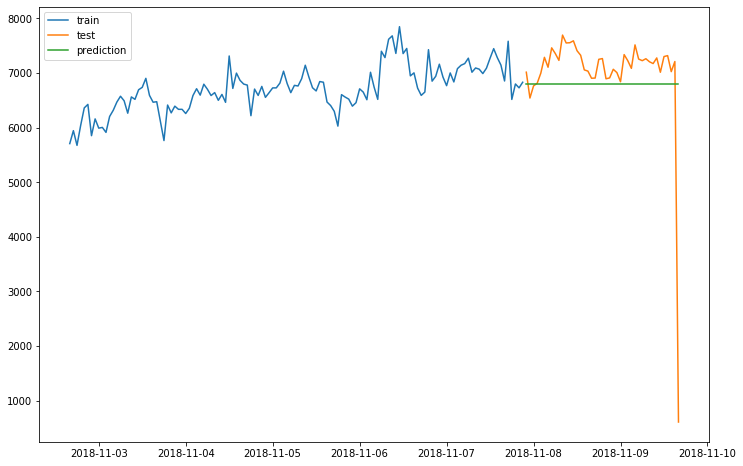

In [110]:
plt.figure(figsize=(12,8))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(pred, label='prediction')
plt.legend(loc='best')
plt.show()

In [80]:

#test['predicted_average']=prediction
r2_score(test,pred)

-0.0060987496527766805

In [73]:
math.sqrt(mean_squared_error(test,pred))

6871.351537575886

In [90]:
from statsmodels.tsa.arima_model import ARMA
from random import random
# contrived dataset
#data = [x + random() for x in range(1, 100)]
# fit model
model = ARMA(train, order=(0,1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(start=test.index[0], end=test.index[-1])
#print(yhat)

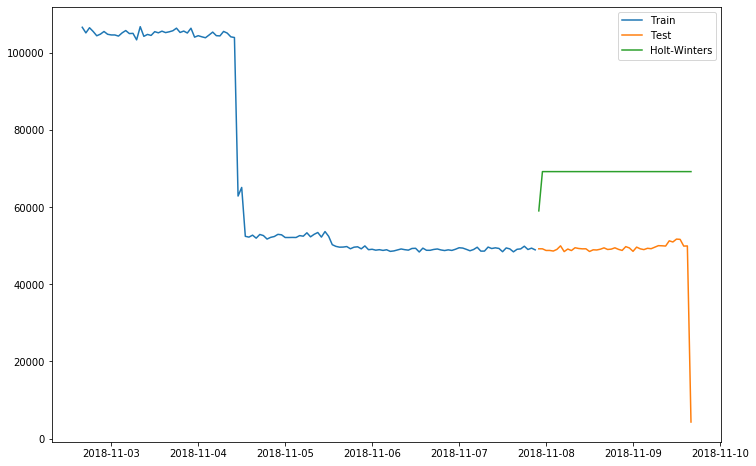

In [91]:
plt.figure(figsize=(12,8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(yhat.index, yhat, label='Holt-Winters')
plt.legend(loc='best')

In [327]:

#from statsmodels.tsa.stattools import adfuller
#from numpy import log
#result = adfuller(df.average)
#print('ADF Statistic: %f' % result[0])
#print('p-value: %f' % result[1])

C:\Users\Svetlana\anaconda33\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)

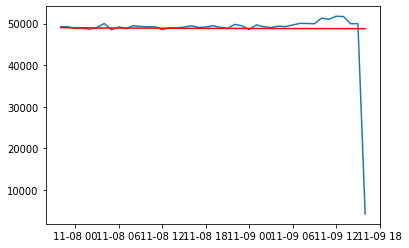

In [75]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
model_ar = AR(train)
model_ar_fit = model_ar.fit()
predictions = model_ar_fit.predict(start=test.index[0], end=test.index[-1])
plt.plot(test)
plt.plot(predictions,color='red')

<h2>модель Хольта-Винтерса</h2>

In [8]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [111]:
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=24, damped=True)
hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=False)
hw_pred = hw_model.predict(start=test.index[0], end=test.index[-1])

C:\Users\Svetlana\anaconda33\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\Svetlana\anaconda33\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [11]:
type(hw_pred)

pandas.core.series.Series

In [44]:
hw_pred.to_dict()

{Timestamp('2018-11-07 22:00:00', freq='60T'): 18569.513369020682,
 Timestamp('2018-11-07 23:00:00', freq='60T'): 18592.875015404818,
 Timestamp('2018-11-08 00:00:00', freq='60T'): 18800.671347421394,
 Timestamp('2018-11-08 01:00:00', freq='60T'): 19116.626667773027,
 Timestamp('2018-11-08 02:00:00', freq='60T'): 19396.289360183753,
 Timestamp('2018-11-08 03:00:00', freq='60T'): 19405.40119317291,
 Timestamp('2018-11-08 04:00:00', freq='60T'): 19348.967711951762,
 Timestamp('2018-11-08 05:00:00', freq='60T'): 19333.284571128162,
 Timestamp('2018-11-08 06:00:00', freq='60T'): 19447.037370884216,
 Timestamp('2018-11-08 07:00:00', freq='60T'): 19490.515212186972,
 Timestamp('2018-11-08 08:00:00', freq='60T'): 19537.001995760897,
 Timestamp('2018-11-08 09:00:00', freq='60T'): 19425.642302995864,
 Timestamp('2018-11-08 10:00:00', freq='60T'): 19332.192265790578,
 Timestamp('2018-11-08 11:00:00', freq='60T'): 19575.946749136958,
 Timestamp('2018-11-08 12:00:00', freq='60T'): 20060.7099193327

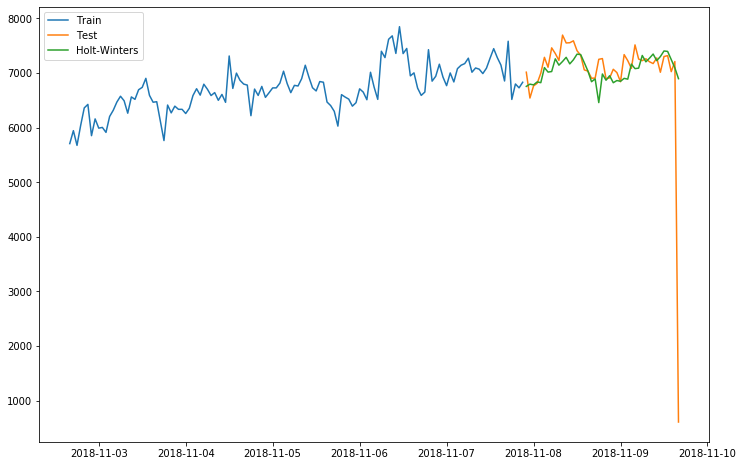

In [112]:
plt.figure(figsize=(12,8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(hw_pred.index, hw_pred, label='Holt-Winters')
plt.legend(loc='best')

In [113]:
r2_score(test,hw_pred)

0.05533949959026163

In [71]:
import math

In [95]:
math.sqrt(mean_squared_error(test, hw_pred))

7196.024488819782